In [4]:
%matplotlib notebook
import h5py
import os
import catdata as cd
from beam_solver.data import DATA_PATH
import numpy as np
import nose.tools as nt
import beam_utils as bt
import pylab
%load_ext autoreload

In [52]:
DATA_PATH = '/Users/Ridhima/Documents/ucb_projects/beam_characterization/smooth/'
# beamfile
#beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beamfits = '/Users/Ridhima/Documents/ucb_projects/beam_characterization/beam_solver/beam_solver/data/HERA_NF_dipole_power.beamfits'
# xx fitsfiles
fitsfile1_xx = os.path.join(DATA_PATH, '2458115.23736.xx.fits')
fitsfile2_xx = os.path.join(DATA_PATH, '2458115.24482.xx.fits')
fitsfile3_xx = os.path.join(DATA_PATH, '2458115.25973.xx.fits')
fitsfiles_xx = [fitsfile1_xx, fitsfile2_xx, fitsfile3_xx]

# yy fitsfiles
fitsfile1_yy = os.path.join(DATA_PATH, '2458115.23736.yy.fits')
fitsfile2_yy = os.path.join(DATA_PATH, '2458115.24482.yy.fits')
fitsfile3_yy = os.path.join(DATA_PATH, '2458115.25973.yy.fits')
fitsfiles_yy = [fitsfile1_xx, fitsfile2_xx, fitsfile3_xx]

# right ascension and declination values
ras = [30.02154061, 27.72922349, 36.75248962, 34.241549]
decs = [-30.88345344, -29.53377208, -30.63958257, -29.93990039]

In [50]:
import glob
fitsfiles_xx = glob.glob('/Users/Ridhima/Documents/ucb_projects/beam_characterization/smooth/2458115.*.xx.fits')
fitsfiles_xx = sorted(fitsfiles_xx)

In [7]:
%autoreload
catd = cd.catData()
srcdict = catd.gen_catalog(fitsfiles_xx, ras, decs, return_data=True)

1.63503916045 -0.366396880215
2.17338907216 0.171953031493
1.63503916045 -0.213575738882
2.17338907216 0.324774172827
1.63503916045 -0.815126814215
2.17338907216 -0.276776902507
1.63503916045 -0.647730772882
2.17338907216 -0.109380861173


In [8]:
beam = bt.get_fitsbeam(beamfits, 151e6)
corrflux = catd.calc_corrflux(beam, 'xx')

[0.50376458 0.92853331]
[0.77688325 0.61032375]
[0.00904878 0.68889768]
[0.07509075 0.95881993]


Casting complex values to real discards the imaginary part


In [9]:
print corrflux
print catd.data_array

[15.32446751 18.37484231  4.69901989  3.09182636]
[[[ 9.16360855 13.44602489]
  [14.54778671 10.86750793]
  [ 0.23727688  3.23458576]
  [ 0.75241214  2.92376137]]]


In [44]:
%autoreload
import beamsolve as bs

In [28]:
bms = bs.BeamSolveBase(cat=catd)
bms.construct_linear_sys(mflux = corrflux)
sol= bms.solve(solver='Linear')

0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
Solving 0/1
Time Elapsed: 0.01 seconds


<IPython.core.display.Javascript object>


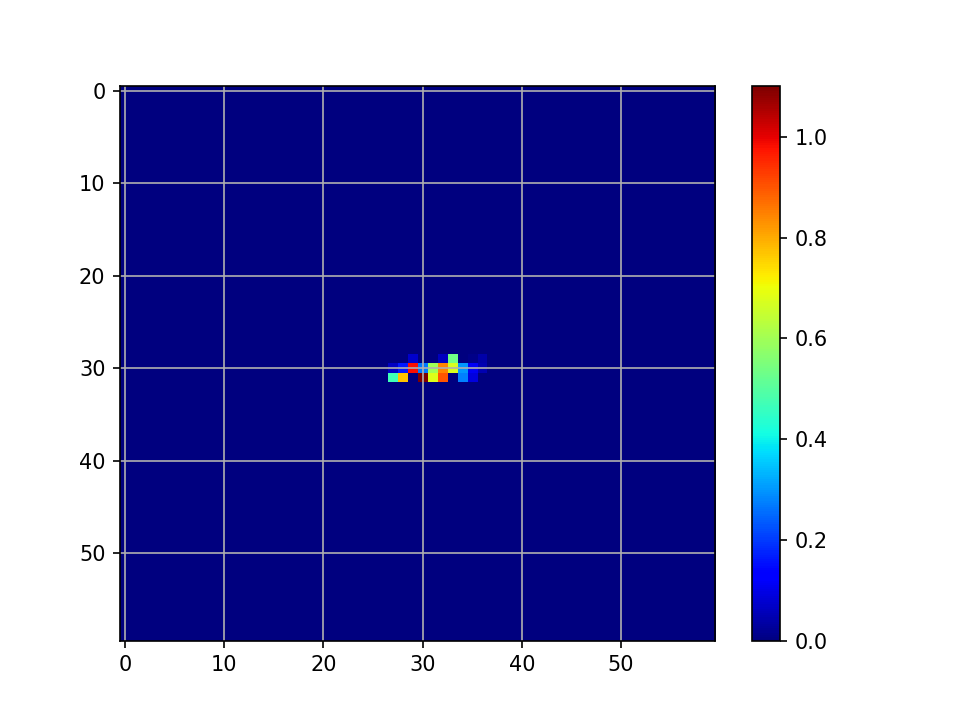

In [33]:
obs_beam = bs.eval_linear_sol(sol, 60)
pylab.imshow(obs_beam.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.colorbar()
pylab.grid()

In [36]:
bms = bs.BeamSolveBase(cat=catd)
bms.construct_linear_sys(mflux = corrflux, theta=[0, np.pi], flip=[1, -1])
sol= bms.solve(solver='Linear')

0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
0
[[ 1. -0.]
 [ 0.  1.]]
0
[[ 1. -0.]
 [ 0.  1.]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
3.14159265359
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
Solving 0/1
Time Elapsed: 0.01 seconds


<IPython.core.display.Javascript object>


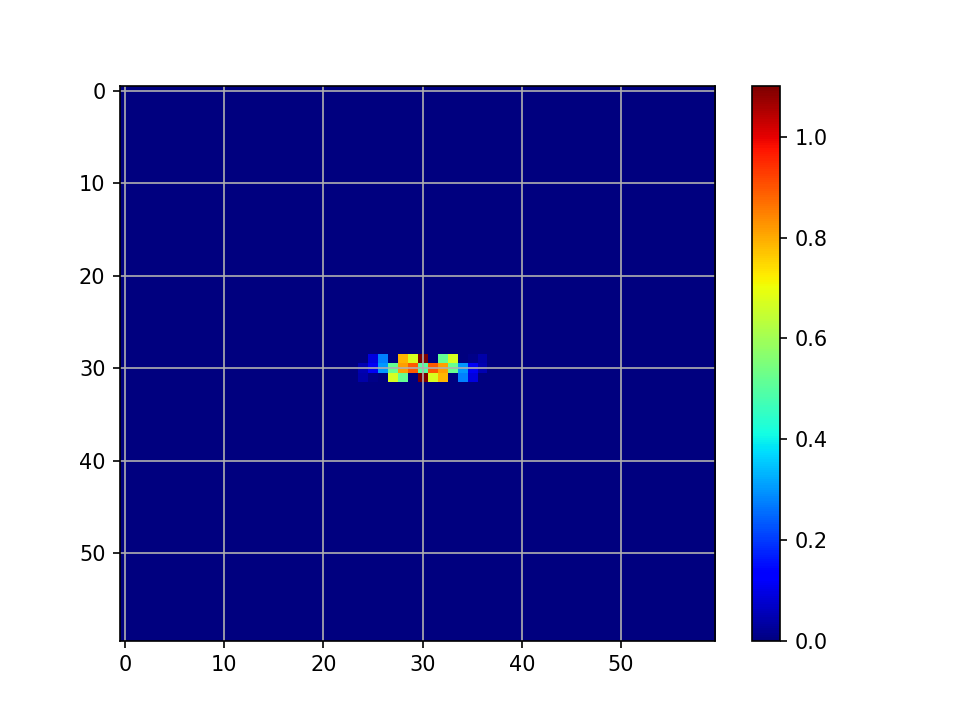

In [37]:
obs_beam = bs.eval_linear_sol(sol, 60)
pylab.imshow(obs_beam.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.colorbar()
pylab.grid()

In [45]:
bms = bs.BeamSolveBase(cat=catd)
bms.construct_nonlinear_sys(mflux = corrflux, bvals=np.zeros((60, 60)), theta=[0, np.pi], flip=[1])
sol= bms.solve(solver='LinProduct')

Beginning iteration 1/50
Solving 0/1
Beginning iteration 2/50
Solving 0/1
Time Elapsed: 0.03 seconds


<IPython.core.display.Javascript object>


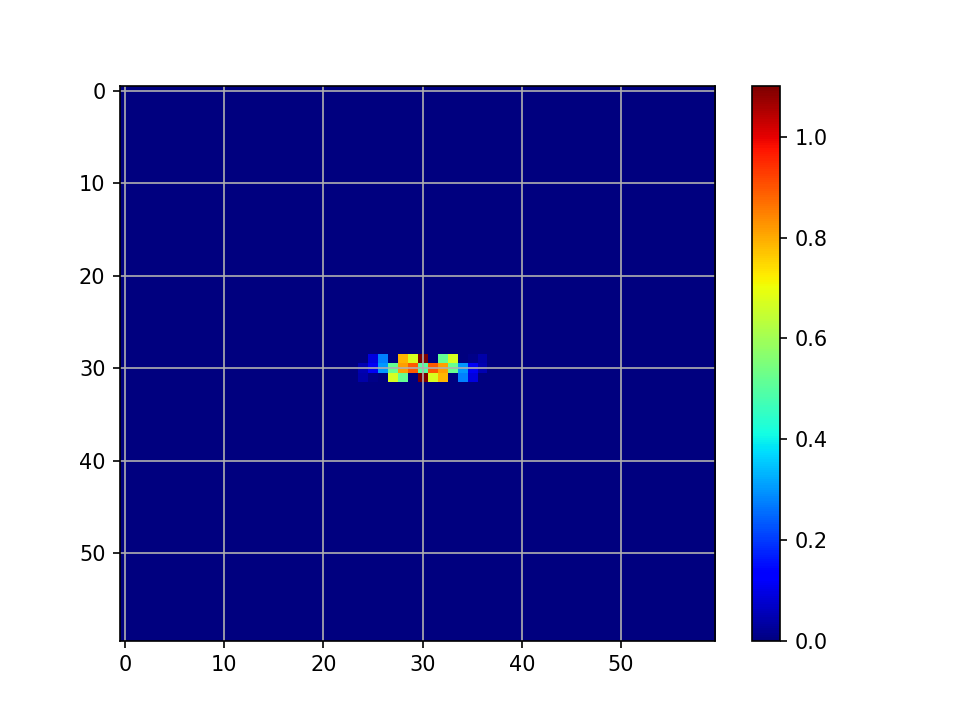

In [51]:
fluxvals, obs_beam1 = bs.eval_nonlinear_sol(sol, catd.Nsrcs, 60)
pylab.imshow(obs_beam1.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.colorbar()
pylab.grid()

In [54]:
%autoreload
catd = cd.catData()
srcdict = catd.gen_polcatalog(fitsfiles_xx, fitsfiles_yy, ras, decs, return_data=True)

In [57]:
beamxx = bt.get_fitsbeam(beamfits, 151e6, 'xx')
corrflux_xx = catd.calc_corrflux(beamxx, 'xx')
beamyy = bt.get_fitsbeam(beamfits, 151e6, 'yy')
corrflux_yy = catd.calc_corrflux(beamyy, 'yy')

[0.50376458 0.86339433 0.92853331]
[0.77688325 0.99972901 0.61032375]
[0.00904878 0.09241452 0.68889768]
[0.07509075 0.29740607 0.95881993]
[0.57406919 0.88587625 0.94012792]
[0.80975139 0.99968739 0.66727754]
[0.0390655  0.16156299 0.73717474]
[0.1412178  0.38087208 0.96402301]


In [61]:
%autoreload
bms = bs.BeamSolveCross(cat=catd)
bms.construct_linear_sys(mflux_xx = corrflux_xx, mflux_yy=corrflux_yy, theta_xx=[0], theta_yy=[np.pi/2], flip=[1])
sol= bms.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.01 seconds


<IPython.core.display.Javascript object>


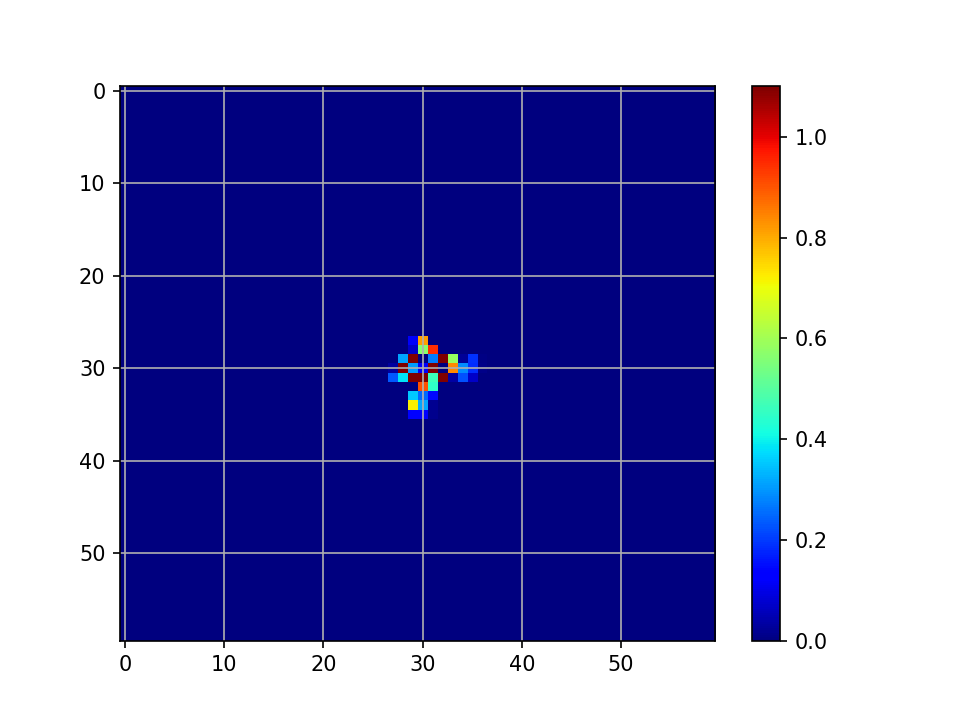

In [63]:
obs_beam = bs.eval_linear_sol(sol, 60)
pylab.imshow(obs_beam.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.colorbar()
pylab.grid()

In [65]:
print corrflux_xx
print corrflux_yy

[15.72849843 17.42781214  4.78297994  3.31226647]
[15.21102599 16.91403183  4.43881675  3.25413009]


In [78]:
%autoreload
bms = bs.BeamSolveCross(cat=catd)
bms.construct_nonlinear_sys(mflux_xx = corrflux_xx, mflux_yy=corrflux_yy, bvals=np.zeros((60, 60)), theta_xx=[0], theta_yy=[np.pi/2], flip=[1])
sol= bms.solve(solver='LinProduct')

Beginning iteration 1/50
Solving 0/1
Beginning iteration 2/50
Solving 0/1
Time Elapsed: 0.06 seconds


<IPython.core.display.Javascript object>


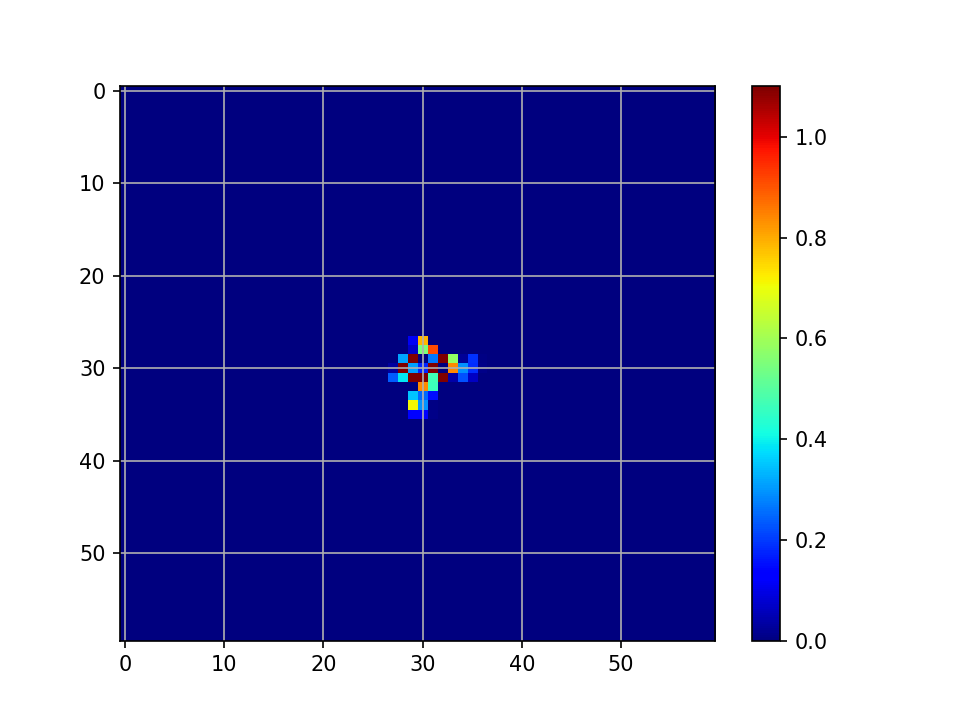

In [82]:
fluxvalx, obs_beam = bs.eval_nonlinear_sol(sol, catd.Nsrcs, 60)
pylab.imshow(obs_beam.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.colorbar()
pylab.grid()